# Strings 2021 Participant Statistics

Here we analyze the Strings 2021 list of participants. The main challenge is to clean up the entries to properly analyze the data.

In [1]:
import tabula
import pandas as pd
import matplotlib.pyplot as plt
import re

We use `tabula-py` to download and extract the tables from the PDF file:

In [415]:
path_to_pdf = "https://www.ictp-saifr.org/wp-content/uploads/2021/06/stringsreg616.pdf"
df_list = tabula.read_pdf(path_to_pdf, pages = "all")
#dfs_local=tabula.read_pdf("strings-table.pdf", pages = "all")

Each PDF page gives a table, so we have to clean them, adjust the columns and append them together into one big table `df_strings`:

In [416]:
## I can only run this once, because it is changing df_list in some steps. Can I fix this?
for i,df in enumerate(df_list):
    if  i == 0 :
        df_list[0].columns = df_list[0].iloc[1]   # Fix column names
        df_strings = df_list[0].drop([0,1]).reset_index(drop=True).astype({"No": int}).copy() # Start df_strings DF
        df_strings.columns.name=''
    else :
        df.loc[len(df)] = list(df.columns) # Adding column names to the bottom.
        df.columns = df_strings.columns  # Fix column names
        df_list_new = df.astype({"No": int}).sort_values('No').reset_index(drop=True).copy() # Transform 'No' column to int64, sort values in ascending order and reset indexes 
        df_strings = df_strings.append(df_list_new, ignore_index=True) # Append DF to the bottom of strings
        
df_strings = df_strings.set_index('No')
df_strings.head()

,Name,Institution,Country,Position
No,,,,
1,"Aalsma, Lars",University of Wisconsin-Madison,United States of America,Postdoc
2,"Abbasi, Navid",LZU,China,Faculty
3,"Abderrazaq, Abassi El",Ibn Tofail University,Morrocco,Graduate student
4,"Abdulhamid, Ibrahim Muhammad","Faculty of Science, Tanta University, Egypt",Egypt,Graduate student
5,"Abe, Yoshihiko",Kyoto Univ.,Japan,Graduate student


Now I want to check and clean the Countries names, as many are neither countries, nor written correctly. Some are even written in another language! Our goal is to do an accurate histogram of countries in the analysis part. First, I will capitalize the strings to make life easier.

In [417]:
df_strings.Country = df_strings.Country.apply(str.capitalize)

In [418]:
df_strings.Country.unique()

array(['United states of america', 'China', 'Morrocco', 'Egypt', 'Japan',
       'India', 'Italy', 'Germany', 'Usa', 'Russia', 'Belgium',
       'Argentina', 'Israel', 'United states', 'Pakistan',
       'United kingdom', 'Bangladesh', 'Netherlands', 'Colombia',
       'France', 'Bulgaria', 'Uk', 'Iran', 'Brasil', 'Brazil',
       'Saudi arabia', 'Denmark', 'Portugal', 'Uruguay', 'Chile',
       'Ecuador', 'South korea', 'Greece', 'Italia',
       'United state of america', 'Spain', 'The netherlands', 'Россия',
       'Canada', 'Australia', 'Singapore', 'Ireland', 'Angola',
       'Switzerland', 'Korea', 'Sweden', 'Perú', 'Turkey', 'South africa',
       'Mexico', 'Morocco', 'Alemania', 'Guatemala', 'Czech republic',
       'P. r. china', 'Belguim', '中国', 'Poland', 'Republic of korea',
       'Hong kong', 'Romania', 'Austria', 'Serbia', 'Czechia',
       'Licenciatura em física', 'Türkiye', 'Francia', 'Uae', 'Us',
       'Venezuela', 'Spagna', 'Ukraine', 'México', 'Thailand', 'Ghana',


In [403]:
df_strings[df_strings.Country.isin(['Sweden & denmark','The netherlands/brazil','Ca','Licenciatura em física'])]

,Name,Institution,Country,Position
No,,,,
399,"Dias, Cid Keythson",Universidade do Estado do Amazonas,Licenciatura em física,Faculty
1291,"Obers, Niels",Nordita & Niels Bohr Institute,Sweden & denmark,Faculty
1385,"Pereira, Duarte Antonio",Radboud University/Fluminense Federal University,The netherlands/brazil,Veni Fellow (Postdoc) @RU and Faculty @UFF
2051,"Zheng, Minshan",UC Davis,Ca,Graduate student


To check the country names, we load a list of all the officially recognized country names in the world:

In [382]:
country_names = pd.read_csv('countries.csv', header=0, names={'Country'},usecols=[1])
country_names.head(10)
#country_names[country_names.Country.str.match(r'^Cze*')]
country_names[country_names.Country.str.contains('russia',flags=re.I)]

,Country
142,Russian Federation


Now are doing an anti-join to find the non-recognizable country names:

In [381]:
country_match = df_strings.merge(country_names, on='Country', how='left', indicator=True)
not_matched_list = country_match.loc[country_match['_merge']=='left_only', 'Country']
df_strings[df_strings.Country.isin(not_matched_list)].Country.sort_values().unique()

array(['England', 'Iran', 'México', 'Other', 'Russia', 'Saudi arabia',
       'Scotland', 'South Korea', 'South africa', 'Taiwan',
       'United Kingdom', 'United States', 'Venezuela', 'Vietnam'],
      dtype=object)

We want to filter and replace country names written in different forms. Later we will also check the outliers and replace city names by the respective countries and any unrecognizable string will be set as 'Other'. We can repeatedly use the following function to make a dictionary of name replacements.

In [419]:
country_replacements = {}
def replacements(regexp, country, value='match'):
    '''Creates a dictionary with pairs regexp:country with all the country replacements. Value gives type of regexp match.'''
    #for regexp, country in args:
    if value == 'match':
        country_names = list(df_strings[df_strings.Country.str.match(regexp,flags=re.I)].Country.unique())
    elif value == 'contains': 
        country_names = list(df_strings[df_strings.Country.str.contains(regexp,flags=re.I)].Country.unique())
    else :
        raise ValueError('Value must be either \'match\' or \'contains\'.')
    for name in country_names:
        country_replacements[name] = country

In [424]:
df_strings[df_strings.Country.str.match('^Ca$',flags=re.I)].Country.unique()

array(['Ca'], dtype=object)

We define a dictionary of replacements `country_dict`, tailored by hand, and use the function `replacements` to make the substitutions in `df_strings`. Is there an easier or more compact way to do this?

In [425]:
country_dict = {'^Ca$': 'Other','Uae': 'United Arab Emirates','United kingdom': 'United Kingdom','Uk':'United Kingdom','美国':'United States','瑞典': 'Sweden','日本':'Japan','中国': 'China','Россия': 'Russia','Österreich': 'Austria','Việt nam': 'Vietnam','Türkiye': 'Turkey','Sweden & denmark':'Other','Spagna': 'Spain','Santa barbara': 'United States','Roc':'Taiwan','R. of north macedonia':'North Macedonia','Polska':'Poland','Perú':'Peru','Países bajos':'Netherlands','The netherlands/brazil':'Other','Nederland':'Netherlands','The netherlands':'Netherlands','Melbourne': 'Australia','The us': 'United States','New york, usa': 'United States','Morrocco':'Morocco','Licenciatura em física': 'Other','korea': ('South Korea','contains'),'Italia':'Italy','Hong kong': 'China', 'P. r. china':'China', 'Hong kong china':'China','Ibaraki': 'Japan', '^Fra*':'France','Estados unidos':'United States','España':'Spain','Cairo':'Egypt', 'Eygpt':'Egypt', r'^Bel\w+':'Belgium','Bahia': 'Brazil','Alemania':'Germany',r'^U.*s.*a*':'United States', r'^Brasil':'Brazil', r'^India':'India', r'^Japa*n*':'Japan', 'Czech republic':'Czechia', }
for key, value in country_dict.items(): 
    if type(value) == str :
        replacements(key,value)
    elif type(value) == tuple :
        replacements(key,value[0],value[1])
    else :
        raise TypeError('Dictionary values must be either strings or a tuple of size 2 (see function \'replacements\').')


In [426]:
country_replacements

{'Ca': 'Other',
 'Uae': 'United Arab Emirates',
 'United kingdom': 'United Kingdom',
 'Uk': 'United Kingdom',
 'Ukraine': 'United Kingdom',
 '美国': 'United States',
 '瑞典': 'Sweden',
 '日本': 'Japan',
 '中国': 'China',
 'Россия': 'Russia',
 'Österreich': 'Austria',
 'Việt nam': 'Vietnam',
 'Türkiye': 'Turkey',
 'Sweden & denmark': 'Other',
 'Spagna': 'Spain',
 'Santa barbara': 'United States',
 'Roc': 'Taiwan',
 'R. of north macedonia': 'North Macedonia',
 'Polska': 'Poland',
 'Perú': 'Peru',
 'Países bajos': 'Netherlands',
 'The netherlands/brazil': 'Netherlands',
 'Nederland': 'Netherlands',
 'The netherlands': 'Netherlands',
 'Melbourne': 'Australia',
 'The us': 'United States',
 'New york, usa': 'United States',
 'Morrocco': 'Morocco',
 'Licenciatura em física': 'Other',
 'South korea': 'South Korea',
 'Korea': 'South Korea',
 'Republic of korea': 'South Korea',
 'Korea (rok)': 'South Korea',
 'Republic of korea(south korea)': 'South Korea',
 'Italia': 'Italy',
 'Hong kong': 'China',
 'H

In [427]:
df_strings.Country = df_strings.Country.replace(country_replacements)

Now we can analyze the positions and institutions. It is more interesting to analyse the positions.

In [408]:
#df_strings.Position.sort_values().unique()

In [ ]:
df_strings.Institution.sort_values().unique()[1:50]

# Let's make some plots! 



## With Seaborn

Let's first use `seaborn` as it is easier to plot. I want to visualize see the countries with most participants.

In [428]:
strings_country_list = list(df_strings.Country.value_counts().index)

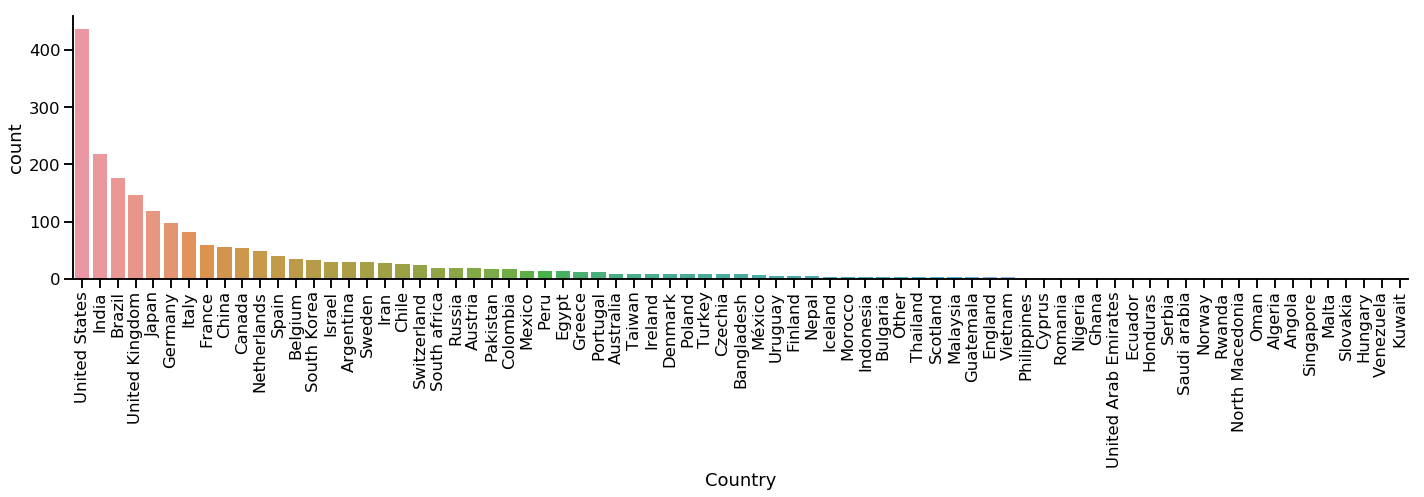

<Figure size 432x288 with 0 Axes>

In [433]:
import seaborn as sns

sns.catplot(x='Country',data=df_strings,kind='count',order=strings_country_list,aspect=4)
#sns.set_context('talk')

plt.xticks(rotation=90)
plt.show()
plt.clf()

In [430]:
top10_countries

['United States',
 'India',
 'Brazil',
 'United Kingdom',
 'Japan',
 'Germany',
 'Italy',
 'France',
 'Other',
 'China']

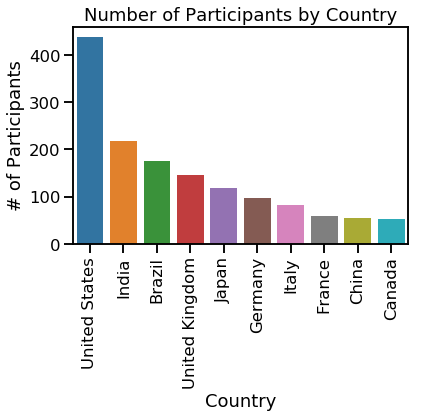

In [431]:
top10_countries = list(df_strings.Country.value_counts().head(10).index)
df_strings_top10 = df_strings[df_strings.Country.isin(top10_countries)]
g = sns.countplot(x='Country',data=df_strings_top10, order=top10_countries)

g.set(ylabel='# of Participants')
g.set_title('Number of Participants by Country')

plt.xticks(rotation=90)
plt.show()

There are too many participants in the `Other` category. Need to check this! 

## With Matplotlib

In [325]:
fig, ax = plt.subplots()

ax.bar(df_strings.Country.value_counts().index,df_strings.Country.value_counts(),rotation=90)
#plt.show()

In [ ]:
# df_strings_BR = df_strings[(df_strings['Country'] == 'Brazil') | (df_strings['Country'] == 'Brasil')]#.sort_values('Institution')
# df_strings_BR.head()

# Miscellaneous